<a href="https://colab.research.google.com/github/raagzz/capstone-project/blob/main/Active_Learning_101.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
##Installing the Packages
!pip install git+https://github.com/modAL-python/modAL.git

  Cloning https://github.com/modAL-python/modAL.git to /tmp/pip-req-build-35y0qfk1
  Running command git clone --filter=blob:none --quiet https://github.com/modAL-python/modAL.git /tmp/pip-req-build-35y0qfk1
  Resolved https://github.com/modAL-python/modAL.git to commit bba6f6fd00dbb862b1e09259b78caf6cffa2e755
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.8/125.8 kB 869.9 kB/s eta 0:00:00
  Created wheel for modAL-python: filename=modAL_python-0.4.2-py3-none-any.whl size=32647 sha256=316478644e24d3dcdac20740b875a40b4c14cf9fd5cf27fa7dde6fbb3b2bf479
  Stored in directory: /tmp/pip-ephem-wheel-cache-mqjwrcq6/wheels/d9/fb/59/7deb61b460c1c36394cd093758986ff7d36f71352dcb2e02c5
Successfully built modAL-python


### Importing the Required Packages

In [2]:
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score

from modAL.models import ActiveLearner
from modAL.uncertainty import uncertainty_sampling, entropy_sampling
from modAL.disagreement import vote_entropy_sampling

### Generating the Data

In [3]:
X, y = make_classification(n_samples=5000, n_features=20, n_informative=15, n_classes=2)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

- Here, 100 data points are randomly chosen as the initial labeled dataset, and the model is first trained on this small set.

In [4]:
### Initial Data For Tarining
initial_idx = np.random.choice(range(len(X_train)), size=100, replace=False)
X_initial, y_initial = X_train[initial_idx], y_train[initial_idx]

- The remaining data points are treated as an unlabeled pool, from which the model can query new instances

In [5]:
### Pool Data - Unlabeled
X_pool = np.delete(X_train, initial_idx, axis=0)
y_pool = np.delete(y_train, initial_idx, axis=0)

### Define Active Learner
- Two strategies used in this notebook
  - Uncertainty Sampling
  - Entropy Sampling

In [6]:
### RF with Uncertainty Sampling
learner_uncertainty = ActiveLearner(
    estimator=RandomForestClassifier(),
    query_strategy=uncertainty_sampling,
    X_training=X_initial, y_training=y_initial
)

In [7]:
### RF with Entropy Sampling
learner_entropy = ActiveLearner(
    estimator=RandomForestClassifier(),
    query_strategy=entropy_sampling,
    X_training=X_initial, y_training=y_initial
)

### Active Learning Parameters
- Number of queries (```n_queries = 50```)
- Accuracy
- F1 Score

In [8]:
### Helper Variables
n_queries = 50
performance_uncertainty = []
performance_entropy = []

### Active Learning Loop | Performace Capture
- Initial Training: The model starts with a small labeled set.
- Query: The model queries a new, most informative data point from the unlabeled pool (based on stargeies it will change).
- Label: The oracle provides the label for the queried point.
- Retraining: The model adds the new data point to its training set and retrains.
- Evaluation: The model's performance is evaluated after each retraining.
- Repeat: The process repeats for a predefined number of queries (in the starter notebook, 50 queries).

In [10]:
def run_active_learning(learner, X_pool, y_pool, strategy_name):
    '''Keeps the loop running and capture the performance of the model'''
    performance = []
    for i in range(n_queries):
        query_idx, _ = learner.query(X_pool)
        learner.teach(X_pool[query_idx], y_pool[query_idx])
        X_pool, y_pool = np.delete(X_pool, query_idx, axis=0), np.delete(y_pool, query_idx, axis=0)
        y_pred = learner.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        performance.append((acc, f1))
        print(f"{strategy_name} | Query {i+1}: Accuracy = {acc:.4f}, F1-Score = {f1:.4f}")
    return performance

### Run active learning and store performance

In [11]:
performance_uncertainty = run_active_learning(learner_uncertainty, X_pool.copy(), y_pool.copy(), "Uncertainty Sampling")
performance_entropy = run_active_learning(learner_entropy, X_pool.copy(), y_pool.copy(), "Entropy Sampling")

Uncertainty Sampling | Query 1: Accuracy = 0.8420, F1-Score = 0.8458
Uncertainty Sampling | Query 2: Accuracy = 0.8413, F1-Score = 0.8470
Uncertainty Sampling | Query 3: Accuracy = 0.8460, F1-Score = 0.8522
Uncertainty Sampling | Query 4: Accuracy = 0.8413, F1-Score = 0.8463
Uncertainty Sampling | Query 5: Accuracy = 0.8493, F1-Score = 0.8551
Uncertainty Sampling | Query 6: Accuracy = 0.8333, F1-Score = 0.8383
Uncertainty Sampling | Query 7: Accuracy = 0.8460, F1-Score = 0.8513
Uncertainty Sampling | Query 8: Accuracy = 0.8593, F1-Score = 0.8643
Uncertainty Sampling | Query 9: Accuracy = 0.8553, F1-Score = 0.8608
Uncertainty Sampling | Query 10: Accuracy = 0.8513, F1-Score = 0.8542
Uncertainty Sampling | Query 11: Accuracy = 0.8520, F1-Score = 0.8557
Uncertainty Sampling | Query 12: Accuracy = 0.8447, F1-Score = 0.8482
Uncertainty Sampling | Query 13: Accuracy = 0.8393, F1-Score = 0.8397
Uncertainty Sampling | Query 14: Accuracy = 0.8520, F1-Score = 0.8526
Uncertainty Sampling | Query 

### Helper Steps for Plotting

In [12]:
acc_uncertainty, f1_uncertainty = zip(*performance_uncertainty)
acc_entropy, f1_entropy = zip(*performance_entropy)
sns.set(style="whitegrid")

### Plotting the Performance over the queries

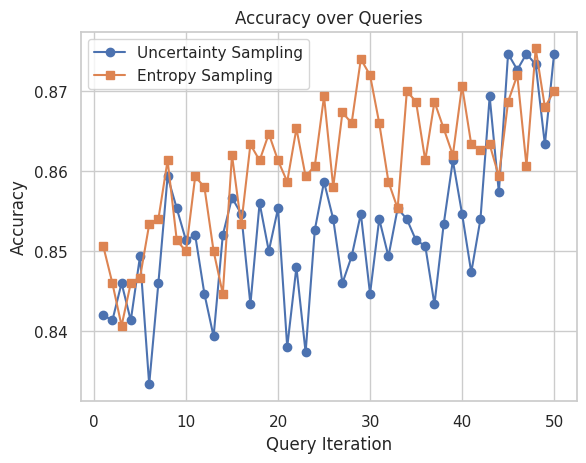

In [15]:
plt.plot(range(1, n_queries + 1), acc_uncertainty, label='Uncertainty Sampling', marker='o')
plt.plot(range(1, n_queries + 1), acc_entropy, label='Entropy Sampling', marker='s')
plt.title("Accuracy over Queries")
plt.xlabel("Query Iteration")
plt.ylabel("Accuracy")
plt.legend()

Text(0, 0.5, 'F1-Score')

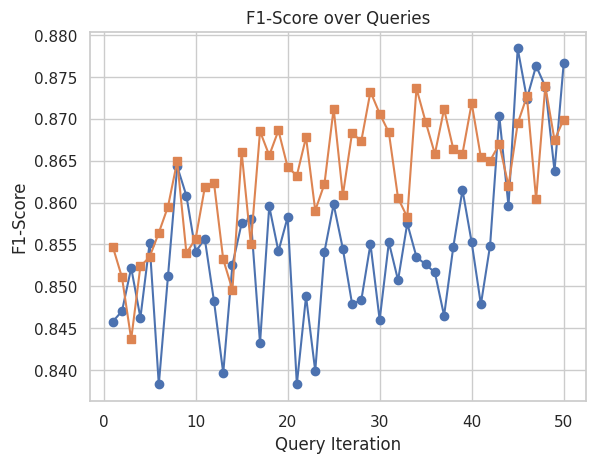

In [18]:
plt.plot(range(1, n_queries + 1), f1_uncertainty, label='Uncertainty Sampling', marker='o')
plt.plot(range(1, n_queries + 1), f1_entropy, label='Entropy Sampling', marker='s')
plt.title("F1-Score over Queries")
plt.xlabel("Query Iteration")
plt.ylabel("F1-Score")